# Land Surface Temperature Analysis and Feature Extraction
This notebook demonstrates how to sample, analyze, and extract features from land surface temperature (LST) and multispectral satellite images for the Austin area. Steps include:
- Loading and visualizing LST data
- Sampling random and hotspot points
- Extracting band values from B2-B9 images
- Calculating vegetation and water indices (NDVI, EVI, NDWI)
- Saving the final dataset

## 1. Load and Visualize Land Surface Temperature (LST) Image
We start by loading the LST TIFF image and displaying it to understand the spatial distribution of surface temperature.

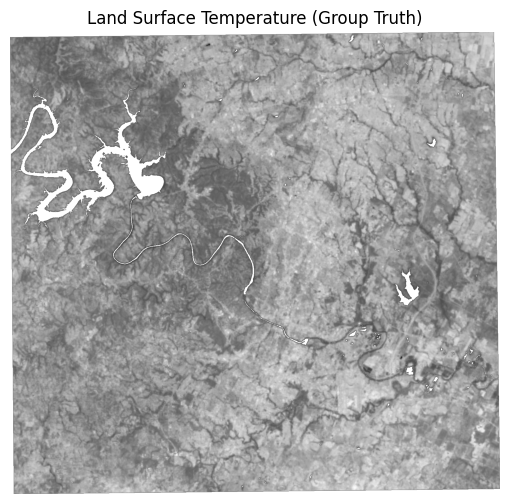

In [36]:
# Show only the Land Surface Temperature TIFF
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

project_path = "/Users/xy5226/Library/CloudStorage/OneDrive-TheUniversityofTexasatAustin/Courses/PGE 383/PGE_383_TermProject_XihanYao/"
# This image may not be available on github due to its size.
lst_path = project_path + "data/Land_surface_temperature.tif"

img = Image.open(lst_path)
arr = np.array(img)

plt.figure(figsize=(8, 6))
plt.imshow(arr, cmap="gray")
plt.title("Land Surface Temperature (Group Truth)")
plt.axis("off")
plt.show()

## 2. Sample 500 Random Points from LST Image
We assume there are ground truth measurment points on the ground.
Randomly select 500 valid pixels from the LST image and store their coordinates and temperature values in a DataFrame.

In [11]:
# Select 500 random samples from img and save coordinates/values in a DataFrame
import numpy as np
import pandas as pd
import rasterio

arr = np.array(img)
with rasterio.open(lst_path) as src:
    transform = src.transform

mask = np.isfinite(arr)
rows, cols = np.where(mask)
np.random.seed(42)
idx = np.random.choice(len(rows), size=500, replace=False)
sample_rows = rows[idx]
sample_cols = cols[idx]
sample_vals = arr[sample_rows, sample_cols]
xs, ys = rasterio.transform.xy(transform, sample_rows, sample_cols)

df = pd.DataFrame({
    "row": sample_rows,
    "col": sample_cols,
    "x": xs,
    "y": ys,
    "land surface temperature": sample_vals
})

df.to_csv("LST_random_samples_500.csv", index=False)
df.head()

,row,col,x,y,land surface temperature
0,264,603,609195.0,3372765.0,314.244171
1,725,924,618825.0,3358935.0,320.116333
2,775,467,605115.0,3357435.0,320.670044
3,1014,538,607245.0,3350265.0,319.979614
4,37,539,607275.0,3379575.0,317.559662


### Visualize Random Sample Points
Overlay the 500 random sample points on the LST image to check their spatial distribution.

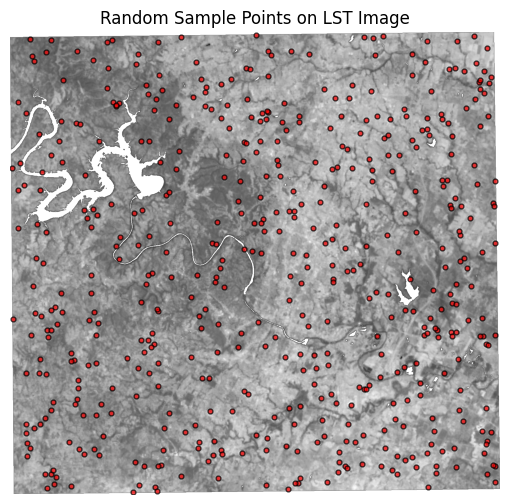

In [12]:
import matplotlib.pyplot as plt

# Plot the image and overlay the sample points
plt.figure(figsize=(8, 6))
plt.imshow(arr, cmap="gray")
plt.scatter(sample_cols, sample_rows, s=12, c="red", edgecolor="black", alpha=0.7)
plt.title("Random Sample Points on LST Image")
plt.axis("off")
plt.show()

## 3. Sample 500 Additional Points Near Hottest Locations
Select 500 more samples near the hottest previously sampled points to better capture temperature extremes.
We assume hotter places are in the urban area, where there are more people and more participants of citizen science, then we will have more temperature samples over there and the samples thus not completely random anymore
Overlay both random and near-hot sample points on the LST image for comparison.

Saved 500 near-hot samples to LST_hot_near_samples_500.csv


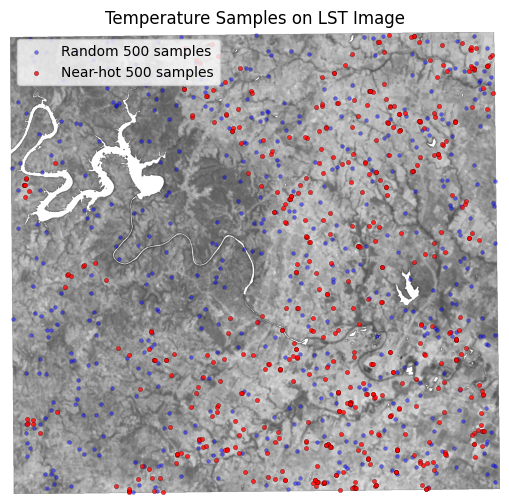

In [37]:
# Take 500 additional samples near previously hottest samples

import numpy as np
import pandas as pd
import rasterio
import matplotlib.pyplot as plt

project_path = "/Users/xy5226/Library/CloudStorage/OneDrive-TheUniversityofTexasatAustin/Courses/PGE 383/PGE_383_TermProject_XihanYao/"
lst_path = project_path + "data/Land_surface_temperature.tif"

# Load raster (band 1) and transform
with rasterio.open(lst_path) as src:
    arr = src.read(1)
    transform = src.transform
    height, width = arr.shape

# Load previous 500 samples
df_prev = pd.read_csv("LST_random_samples_500.csv")

# Pick seeds = previous "high" LST samples (top 20%)
q = df_prev["land surface temperature"].quantile(0.80)
seeds_df = df_prev[df_prev["land surface temperature"] >= q][["row", "col"]].astype(int)
seed_coords = seeds_df.to_numpy()
if seed_coords.size == 0:
    # fallback to top 100 hottest samples
    seeds_df = df_prev.sort_values("land surface temperature", ascending=False).head(100)[["row", "col"]].astype(int)
    seed_coords = seeds_df.to_numpy()

rng = np.random.default_rng(42)
target = 500
half_size = 50  # 7x7 window around seed
results = []
seen = set()

def local_hotspot(arr, r, c, half=3):
    h, w = arr.shape
    r0 = max(0, r - half); r1 = min(h, r + half + 1)
    c0 = max(0, c - half); c1 = min(w, c + half + 1)
    sub = arr[r0:r1, c0:c1]
    mask = np.isfinite(sub)
    if not np.any(mask):
        return r, c, arr[r, c]
    # choose the max within the window
    vals = sub[mask]
    imax = np.argmax(vals)
    flat = np.flatnonzero(mask)[imax]
    rr, cc = np.unravel_index(flat, sub.shape)
    rr += r0; cc += c0
    # if the max is the seed itself, try a nearby high alternative
    if rr == r and cc == c:
        pct90 = np.nanpercentile(vals, 90)
        high_mask = (sub >= pct90) & mask
        cand = np.column_stack(np.where(high_mask))
        if cand.shape[0] > 1:
            # pick any candidate not equal to center
            choices = [(a, b) for a, b in cand if not (a == rr - r0 and b == cc - c0)]
            if choices:
                a, b = choices[rng.integers(0, len(choices))]
                rr, cc = r0 + a, c0 + b
    return rr, cc, arr[rr, cc]

# Generate neighbors near hot seeds
max_iters = 20000
iters = 0
while len(results) < target and iters < max_iters:
    iters += 1
    # pick a seed
    sr, sc = seed_coords[rng.integers(0, len(seed_coords))]
    # small random jitter around seed to diversify nearby search
    jr = int(np.clip(sr + rng.integers(-70, 71), 0, height - 1))
    jc = int(np.clip(sc + rng.integers(-70, 71), 0, width - 1))
    if not np.isfinite(arr[jr, jc]):
        continue
    rr, cc, val = local_hotspot(arr, jr, jc, half=half_size)
    if not np.isfinite(val):
        continue
    key = (int(rr), int(cc))
    if key in seen:
        continue
    seen.add(key)
    results.append((int(rr), int(cc), float(val)))

# Convert to coordinates
rows = [r for r, c, v in results]
cols = [c for r, c, v in results]
xs, ys = rasterio.transform.xy(transform, rows, cols)

hot_df = pd.DataFrame({
    "row": rows,
    "col": cols,
    "x": xs,
    "y": ys,
    "land surface temperature": [v for _, _, v in results]
})

# Save and quick plot
hot_df.to_csv("LST_hot_near_samples_500.csv", index=False)
print(f"Saved {len(hot_df)} near-hot samples to LST_hot_near_samples_500.csv")

plt.figure(figsize=(8, 6))
plt.imshow(arr, cmap="gray")
plt.scatter(df_prev["col"], df_prev["row"], s=8, c="blue", edgecolor="black", linewidth=0.2, alpha=0.5, label="Random 500 samples")
plt.scatter(hot_df["col"], hot_df["row"], s=10, c="red", edgecolor="black", linewidth=0.2, alpha=0.8, label="Near-hot 500 samples")
plt.legend()
plt.title("Temperature Samples on LST Image")
plt.axis("off")
plt.show()

In [14]:
df_500 = pd.read_csv("LST_random_samples_500.csv")
df_hot = pd.read_csv("LST_hot_near_samples_500.csv")

## 4. Combine All Sample Points
Merge the random and near-hot sample DataFrames into a single DataFrame for further analysis.

In [17]:
df = pd.concat([df_500, df_hot], ignore_index=True)
df.tail(5)

,row,col,x,y,land surface temperature
995,1451,1724,642825.0,3337155.0,330.284943
996,507,1465,635055.0,3365475.0,331.696594
997,1624,545,607455.0,3331965.0,326.983124
998,507,1464,635025.0,3365475.0,330.643829
999,475,1293,629895.0,3366435.0,328.046143


### Visualize Combined Sample Points by Temperature
Plot all sample points on the LST image, coloring each point by its temperature value.

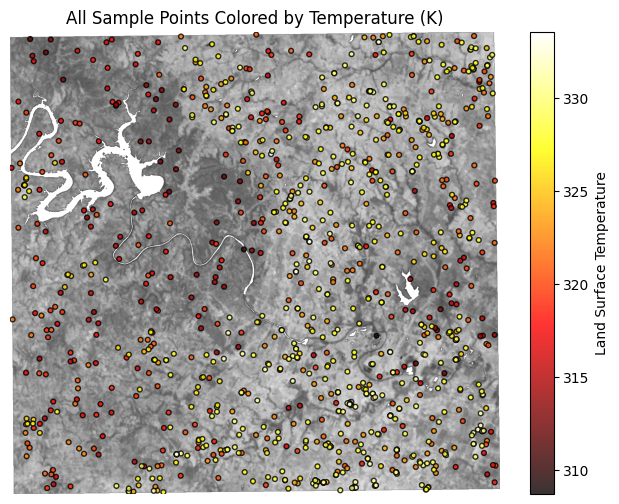

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.imshow(arr, cmap="gray")
sc = plt.scatter(df["col"], df["row"], c=df["land surface temperature"], cmap="hot", s=12, edgecolor="black", alpha=0.8)
plt.colorbar(sc, label="Land Surface Temperature")
plt.title("All Sample Points Colored by Temperature (K)")
plt.axis("off")
plt.show()

## 5. Overlay Sample Points on Multispectral Band Image
Display the sample points on a selected band image (e.g., B2-B9) to visualize their locations relative to the satellite data.

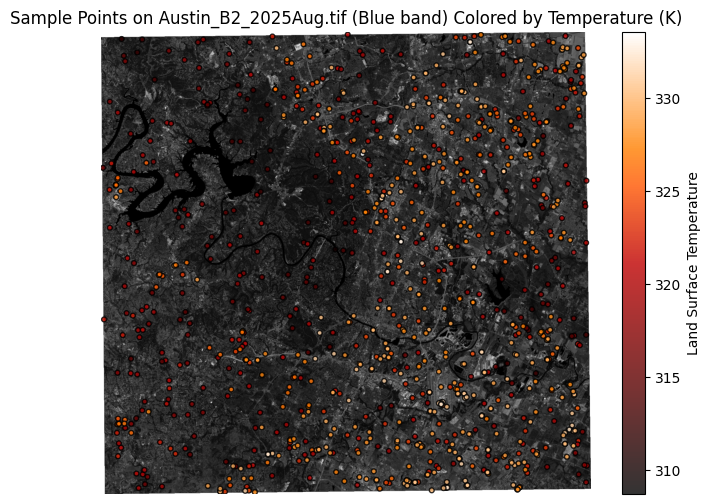

In [40]:
import rasterio
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Load the new TIFF image
b2_path = "/Users/xy5226/Library/CloudStorage/OneDrive-TheUniversityofTexasatAustin/Courses/PGE 383/PGE_383_TermProject_XihanYao/data/Austin_B7_2025Aug.tif"
with rasterio.open(b2_path) as src:
    b2_arr = src.read(1)

plt.figure(figsize=(8, 6))
plt.imshow(b2_arr, cmap="gray")
sc = plt.scatter(df["col"], df["row"], c=df["land surface temperature"], cmap="gist_heat", s=12, edgecolor="black", alpha=0.8)
plt.colorbar(sc, label="Land Surface Temperature")
plt.title("Sample Points on Austin_B2_2025Aug.tif (Blue band) Colored by Temperature (K)")
plt.axis("off")
plt.show()

## 6. Extract Band Values for Each Sample Point
For each sample point, extract the pixel value from bands B2 to B9 and add them as new columns in the DataFrame.

In [20]:
import rasterio

for band in range(2, 10):
    tif_path = f"/Users/xy5226/Library/CloudStorage/OneDrive-TheUniversityofTexasatAustin/Courses/PGE 383/PGE_383_TermProject_XihanYao/data/Austin_B{band}_2025Aug.tif"
    with rasterio.open(tif_path) as src:
        arr = src.read(1)
        # Get value at each sample point
        df[f"B{band}"] = arr[df["row"], df["col"]]

In [21]:
df.tail(5)

,row,col,x,y,land surface temperature,B2,B3,B4,B5,B6,B7,B8,B9
995,1451,1724,642825.0,3337155.0,330.284943,0.257345,0.229267,0.253368,0.466649,0.543651,0.375880,0.105432,0.001045
996,507,1465,635055.0,3365475.0,331.696594,0.279925,0.289051,0.207447,0.397914,0.238178,0.153747,0.113968,0.001312
997,1624,545,607455.0,3331965.0,326.983124,0.293555,0.280335,0.291098,0.725909,0.496580,0.272808,0.113901,0.001134
998,507,1464,635025.0,3365475.0,330.643829,0.288759,0.290279,0.219615,0.430146,0.226244,0.146220,0.116658,0.001111
999,475,1293,629895.0,3366435.0,328.046143,0.419149,0.429854,0.450620,0.699234,0.453253,0.328420,0.182767,0.001200


### Rename Band Columns and Clean Up
Rename band columns to descriptive names (e.g., B2_blue, B3_green) and remove old band columns for clarity.

In [32]:
import rasterio

band_names = {
    2: "B2_blue",
    3: "B3_green",
    4: "B4_red",
    5: "B5_NIR",
    6: "B6_SWIR1",
    7: "B7_SWIR2",
    8: "B8_pan",
    9: "B9_cirrus"
}

# Add new columns with correct names
for band, name in band_names.items():
    tif_path = f"/Users/xy5226/Library/CloudStorage/OneDrive-TheUniversityofTexasatAustin/Courses/PGE 383/PGE_383_TermProject_XihanYao/data/Austin_B{band}_2025Aug.tif"
    with rasterio.open(tif_path) as src:
        arr = src.read(1)
        df[name] = arr[df["row"], df["col"]]

# Drop old columns B2 to B9 if they exist
df = df.drop([f"B{band}" for band in range(2, 10) if f"B{band}" in df.columns], axis=1)
df.tail(5)

,row,col,x,y,land surface temperature,B2_blue,B3_green,B4_red,B5_NIR,B6_SWIR1,B7_SWIR2,B8_pan,B9_cirrus
995,1451,1724,642825.0,3337155.0,330.284943,0.257345,0.229267,0.253368,0.466649,0.543651,0.375880,0.105432,0.001045
996,507,1465,635055.0,3365475.0,331.696594,0.279925,0.289051,0.207447,0.397914,0.238178,0.153747,0.113968,0.001312
997,1624,545,607455.0,3331965.0,326.983124,0.293555,0.280335,0.291098,0.725909,0.496580,0.272808,0.113901,0.001134
998,507,1464,635025.0,3365475.0,330.643829,0.288759,0.290279,0.219615,0.430146,0.226244,0.146220,0.116658,0.001111
999,475,1293,629895.0,3366435.0,328.046143,0.419149,0.429854,0.450620,0.699234,0.453253,0.328420,0.182767,0.001200


## 7. Calculate Vegetation and Water Indices
Compute NDVI, EVI, and NDWI for each sample point using the extracted band values.

In [33]:
import numpy as np

# NDVI: (NIR - Red) / (NIR + Red)
df["NDVI"] = (df["B5_NIR"] - df["B4_red"]) / (df["B5_NIR"] + df["B4_red"])

# EVI: 2.5 * (NIR - Red) / (NIR + 6*Red - 7.5*Blue + 1)
df["EVI"] = 2.5 * (df["B5_NIR"] - df["B4_red"]) / (
    df["B5_NIR"] + 6 * df["B4_red"] - 7.5 * df["B2_blue"] + 1
)

# NDWI: (Green - NIR) / (Green + NIR)
df["NDWI"] = (df["B3_green"] - df["B5_NIR"]) / (df["B3_green"] + df["B5_NIR"])
df.tail(5)

,row,col,x,y,land surface temperature,B2_blue,B3_green,B4_red,B5_NIR,B6_SWIR1,B7_SWIR2,B8_pan,B9_cirrus,NDVI,EVI,NDWI
995,1451,1724,642825.0,3337155.0,330.284943,0.257345,0.229267,0.253368,0.466649,0.543651,0.375880,0.105432,0.001045,0.296217,0.504562,-0.341107
996,507,1465,635055.0,3365475.0,331.696594,0.279925,0.289051,0.207447,0.397914,0.238178,0.153747,0.113968,0.001312,0.314634,0.876666,-0.158470
997,1624,545,607455.0,3331965.0,326.983124,0.293555,0.280335,0.291098,0.725909,0.496580,0.272808,0.113901,0.001134,0.427539,0.855364,-0.442809
998,507,1464,635025.0,3365475.0,330.643829,0.288759,0.290279,0.219615,0.430146,0.226244,0.146220,0.116658,0.001111,0.324014,0.904119,-0.194145
999,475,1293,629895.0,3366435.0,328.046143,0.419149,0.429854,0.450620,0.699234,0.453253,0.328420,0.182767,0.001200,0.216213,0.493539,-0.238582


## 8. Save Final Dataset
Export the DataFrame with all sample points, band values, and indices to a CSV file for further analysis.

In [34]:
df.to_csv("LST_samples_with_bands_and_indices.csv", index=False)